In [1]:
import numpy as np
import xarray as xr
import os
import glob
from pathlib import Path
import pathlib
from pprint import pprint
import matplotlib.pyplot as plt
import time
import requests
import s3fs
from os.path import dirname, join

In [2]:
alongtrack_file_dir = Path('~/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output/')
grids_file_dir = Path('~/Data/ECCO_GMSL/gridding_output/')
main_dir = Path('~/ECCO_GMSL/')
fig_dir = Path('~/Figures/ECCO_GMSL/')

# Compute ECCO along track GMSL Beckley's style
### Compute the reference global mean SSH over 20 years 1996-2016

In [3]:
ECCO_alongtrack_files=[]
for year in range(1996,2017):
    ECCO_alongtrack_files_tmp = list(alongtrack_file_dir.glob('*ECCO_V4r4_alongtrack_SSH_*'+str(year)+'*nc'))
    ECCO_alongtrack_files.extend(ECCO_alongtrack_files_tmp)
print(np.sort(ECCO_alongtrack_files))

[]


In [4]:
start_time = time.time()
alongtrack = xr.open_mfdataset(
        paths=ECCO_alongtrack_files,
        combine='nested',
        concat_dim='i',
        decode_cf=True,
        compat='override',
        coords='minimal',
        chunks={'time': 1}  
    )  
print(time.time() - start_time)
alongtrack

260.7494957447052


<xarray.Dataset>
Dimensions:     (i: 453189719)
Coordinates:
    time        datetime64[ns] ...
    cycle_day   int64 ...
    delta_days  int64 ...
    lon         (i) float32 dask.array<chunksize=(47217,), meta=np.ndarray>
    lat         (i) float32 dask.array<chunksize=(47217,), meta=np.ndarray>
Dimensions without coordinates: i
Data variables:
    SSH_at_xy   (i) float32 dask.array<chunksize=(47217,), meta=np.ndarray>

In [5]:
ref_mean=alongtrack.SSH_at_xy.mean().values
print(ref_mean)

-0.10504536


### Compute GMSL 10-day time series

In [6]:
ECCO_alongtrack_files = list(alongtrack_file_dir.glob('*ECCO_V4r4_alongtrack_SSH_*nc'))
ECCO_alongtrack_files=np.sort(ECCO_alongtrack_files)
print(ECCO_alongtrack_files)

[PosixPath('/home/jovyan/GMSL/ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-01.nc')
 PosixPath('/home/jovyan/GMSL/ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-02.nc')
 PosixPath('/home/jovyan/GMSL/ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-03.nc')
 ...
 PosixPath('/home/jovyan/GMSL/ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_2017-12-29.nc')
 PosixPath('/home/jovyan/GMSL/ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_2017-12-30.nc')
 PosixPath('/home/jovyan/GMSL/ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_2017-12-31.nc')]


In [7]:
Vs = 7.2 #satellite along track velocity in km/s
Ve = 0.46 #velocity of earth's rotation at the equator in km/s
incidence = np.deg2rad(66.04) #satellite inclination
sig = 1 #uncertainty
alpha = np.arcsin(np.abs(np.cos(incidence)/np.cos(0)))
gamma = np.arctan(np.abs( (Vs*np.sin(alpha)-Ve*np.cos(0)) / (Vs*np.cos(alpha)) ))
beta0=np.pi/2 - gamma
np.rad2deg(beta0)

69.47012797034805

In [8]:
start_time = time.time()
alongtrack_gmsl_tmp=[]
for i in np.arange(0,len(ECCO_alongtrack_files),10):
    ECCO_alongtrack_files_cycle=ECCO_alongtrack_files[i:i+10]
    alongtrack = xr.open_mfdataset(
            paths=ECCO_alongtrack_files_cycle,
            combine='nested',
            concat_dim='i',
            decode_cf=True,
            compat='override',
            coords='minimal',
            chunks={'time': 1}  
        )  
    SSH_at_xy_ano=alongtrack.SSH_at_xy-ref_mean
    alpha = np.arcsin(np.abs(np.cos(incidence)/np.cos(np.deg2rad(alongtrack.lat))))
    gamma = np.arctan(np.abs( (Vs*np.sin(alpha)-Ve*np.cos(np.deg2rad(alongtrack.lat))) / (Vs*np.cos(alpha)) ))
    beta = np.pi/2 - gamma
    w=np.sin(beta)/np.sin(beta0) #From Nerem 1995
    alongtrack_gmsl_tmp.append((SSH_at_xy_ano*w).sum()/w.sum())
alongtrack_gmsl = xr.concat(alongtrack_gmsl_tmp, dim='time')
print(time.time() - start_time)

291.1729578971863


In [9]:
alongtrack_gmsl=alongtrack_gmsl.drop('cycle_day')
alongtrack_gmsl=alongtrack_gmsl.drop('delta_days')
alongtrack_gmsl.name = 'gmsl_ecco_alongtrack'
alongtrack_gmsl.attrs['units'] = 'm'
alongtrack_gmsl.attrs['summary'] = '10-day GMSL time series computed on the alongtrack ECCO data, referenced to a 1996-2016 global mean SSH'
alongtrack_gmsl.time.attrs['long_name'] = 'first day of the 10-day average'
alongtrack_gmsl['time']=alongtrack_gmsl.time+(4*24*60*60*10**(9))
alongtrack_gmsl

<xarray.DataArray 'gmsl_ecco_alongtrack' (time: 950)>
dask.array<concatenate, shape=(950,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-05T18:00:00 ... 2017-12-29T12:00:00
Attributes:
    units:    m
    summary:  10-day GMSL time series computed on the alongtrack ECCO data, r...

### Plot GMSL from along track ECCO data

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in arcsin
  return func(*(_execute_task(a, cache) for a in args))


221.64040350914001


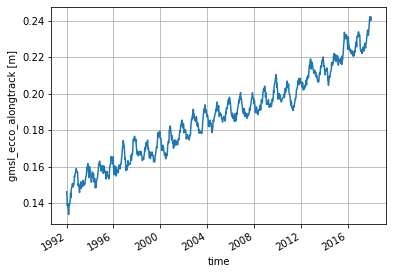

In [10]:
start_time = time.time()
alongtrack_gmsl.plot();
plt.grid()
plt.title('')
plt.savefig(fig_dir / 'GMSL_ecco_alongtrack.png',dpi=200,transparent=False,facecolor='white')
print(time.time() - start_time)

# Beckley GMSL time series

### Open the Beckley time series dataset

In [11]:
gmsl_beckley = xr.open_dataset(str(main_dir) + '/GMSL_Beckley_v51.nc')
gmsl_beckley

<xarray.Dataset>
Dimensions:                (time: 1061)
Coordinates:
  * time                   (time) datetime64[ns] 1993-01-05 ... 2021-10-25
Data variables:
    gmsl                   (time) float64 ...
    gmsl_nongia            (time) float64 ...
    gmsl_smoothed          (time) float64 ...
    gmsl_smoothed_anoseas  (time) float64 ...

### Add Beckley GMSL time series to the ECCO along track GMSL time series

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in arcsin
  return func(*(_execute_task(a, cache) for a in args))


257.9999990463257


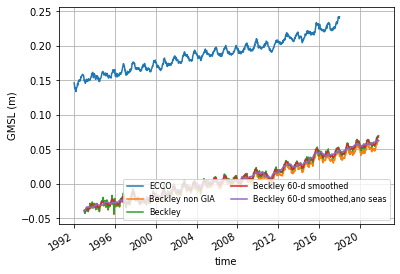

In [12]:
start_time = time.time()
alongtrack_gmsl.plot(label='ECCO');
gmsl_beckley.gmsl_nongia.plot(label='Beckley non GIA');
gmsl_beckley.gmsl.plot(label='Beckley');
gmsl_beckley.gmsl_smoothed.plot(label='Beckley 60-d smoothed');
gmsl_beckley.gmsl_smoothed_anoseas.plot(label='Beckley 60-d smoothed,ano seas');
plt.grid()
plt.title('')
plt.ylabel('GMSL (m)')
plt.legend(ncol=2, loc='lower right',fontsize=8)
plt.savefig(fig_dir / 'GMSL_ecco_alongtrack_beckley.png',dpi=200,transparent=False,facecolor='white')
print(time.time() - start_time)

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in arcsin
  return func(*(_execute_task(a, cache) for a in args))


205.98031640052795


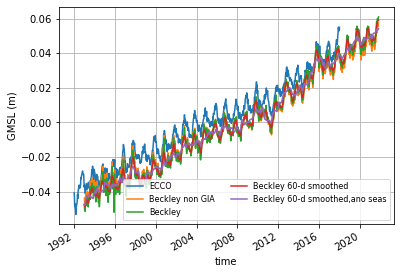

In [13]:
start_time = time.time()
(alongtrack_gmsl-alongtrack_gmsl.mean()).plot(label='ECCO');
(gmsl_beckley.gmsl_nongia-gmsl_beckley.gmsl_nongia.mean()).plot(label='Beckley non GIA');
(gmsl_beckley.gmsl-gmsl_beckley.gmsl.mean()).plot(label='Beckley');
(gmsl_beckley.gmsl_smoothed-gmsl_beckley.gmsl_smoothed.mean()).plot(label='Beckley 60-d smoothed');
(gmsl_beckley.gmsl_smoothed_anoseas-gmsl_beckley.gmsl_smoothed_anoseas.mean()).plot(label='Beckley 60-d smoothed,ano seas');
plt.grid()
plt.title('')
plt.ylabel('GMSL (m)')
plt.legend(ncol=2, loc='lower right',fontsize=8)
plt.savefig(fig_dir / 'GMSL_ecco_alongtrack_beckley_refmean.png',dpi=200,transparent=False,facecolor='white')
print(time.time() - start_time)

### Save Beckley GMSL time series to netCDF

In [14]:
filename = main_dir / ('GMSL_ECCO_alongtrack_19922017.nc')
alongtrack_gmsl.to_netcdf(filename)

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in arcsin
  return func(*(_execute_task(a, cache) for a in args))


# Compute GMSL from ECCO synthetic grids

In [15]:
# After running Kevin's code simple gridder.py, grids are generating
ECCO_grids_files = list(grids_file_dir.glob('*SSHA_gridded_*nc'))
ECCO_grids_files=np.sort(ECCO_grids_files)
print(ECCO_grids_files[0:5])
print('...')
print(ECCO_grids_files[-5:-1])

[PosixPath('/home/jovyan/GMSL/gridding_output/SSHA_gridded_1992-01-05.nc')
 PosixPath('/home/jovyan/GMSL/gridding_output/SSHA_gridded_1992-01-15.nc')
 PosixPath('/home/jovyan/GMSL/gridding_output/SSHA_gridded_1992-01-25.nc')
 PosixPath('/home/jovyan/GMSL/gridding_output/SSHA_gridded_1992-02-04.nc')
 PosixPath('/home/jovyan/GMSL/gridding_output/SSHA_gridded_1992-02-14.nc')]
...
[PosixPath('/home/jovyan/GMSL/gridding_output/SSHA_gridded_2017-11-19.nc')
 PosixPath('/home/jovyan/GMSL/gridding_output/SSHA_gridded_2017-11-29.nc')
 PosixPath('/home/jovyan/GMSL/gridding_output/SSHA_gridded_2017-12-09.nc')
 PosixPath('/home/jovyan/GMSL/gridding_output/SSHA_gridded_2017-12-19.nc')]


In [16]:
start_time = time.time()
grids = xr.open_mfdataset(
        paths=ECCO_grids_files,
        combine='nested',
        concat_dim='time',
        decode_cf=True,
        compat='override',
        coords='minimal',
        chunks={'time': 1}  
    )   
print(time.time() - start_time)
grids

51.65978527069092


<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 360, time: 950)
Coordinates:
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time       (time) datetime64[ns] 1992-01-05 1992-01-15 ... 2017-12-29
Data variables:
    SSHA       (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    counts     (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    mask       (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes:
    gridding_method:  Gridded using pyresample resample_gauss with roi=600000...

### Area weighted

In [17]:
weights = np.cos(np.deg2rad(grids.latitude))
weights.name = "weights"
weights

<xarray.DataArray 'weights' (latitude: 360)>
array([0.00436336, 0.0130896 , 0.02181496, 0.03053854, 0.03925979,
       0.04797817, 0.05669278, 0.06540319, 0.0741085 , 0.08280817,
       0.09150165, 0.10018805, 0.10886693, 0.1175374 , 0.12619892,
       0.13485095, 0.1434926 , 0.15212344, 0.16074257, 0.16934957,
       0.17794356, 0.186524  , 0.19509035, 0.20364174, 0.21217772,
       0.22069745, 0.22920035, 0.23768592, 0.24615327, 0.25460202,
       0.2630312 , 0.27144054, 0.27982906, 0.28819627, 0.29654163,
       0.30486432, 0.31316388, 0.32143947, 0.32969064, 0.33791676,
       0.34611705, 0.3542911 , 0.36243805, 0.3705574 , 0.37864864,
       0.38671094, 0.39474392, 0.4027467 , 0.41071892, 0.41865978,
       0.42656872, 0.4344453 , 0.4422887 , 0.4500985 , 0.45787394,
       0.4656145 , 0.4733197 , 0.48098874, 0.48862126, 0.49621648,
       0.50377405, 0.5112931 , 0.5187732 , 0.52621394, 0.5336145 ,
       0.54097444, 0.54829323, 0.55557024, 0.56280494, 0.5699967 ,
       0.57714516, 0.5842497 , 0.59130967, 0.5983246 , 0.605294  ,
       0.61221725, 0.61909395, 0.62592345, 0.63270533, 0.639439  ,
       0.646124  , 0.65275973, 0.6593458 , 0.66588163, 0.6723668 ,
       0.67880076, 0.685183  , 0.691513  , 0.69779044, 0.7040147 ,
       0.7101854 , 0.716302  , 0.72236395, 0.72837096, 0.7343225 ,
       0.7402181 , 0.7460574 , 0.7518398 , 0.757565  , 0.76323247,
...
       0.7343225 , 0.72837096, 0.72236395, 0.716302  , 0.7101854 ,
       0.7040147 , 0.69779044, 0.691513  , 0.685183  , 0.67880076,
       0.6723668 , 0.66588163, 0.6593458 , 0.65275973, 0.646124  ,
       0.639439  , 0.63270533, 0.62592345, 0.61909395, 0.61221725,
       0.605294  , 0.5983246 , 0.59130967, 0.5842497 , 0.57714516,
       0.5699967 , 0.56280494, 0.55557024, 0.54829323, 0.54097444,
       0.5336145 , 0.52621394, 0.5187732 , 0.5112931 , 0.50377405,
       0.49621648, 0.48862126, 0.48098874, 0.4733197 , 0.4656145 ,
       0.45787394, 0.4500985 , 0.4422887 , 0.4344453 , 0.42656872,
       0.41865978, 0.41071892, 0.4027467 , 0.39474392, 0.38671094,
       0.37864864, 0.3705574 , 0.36243805, 0.3542911 , 0.34611705,
       0.33791676, 0.32969064, 0.32143947, 0.31316388, 0.30486432,
       0.29654163, 0.28819627, 0.27982906, 0.27144054, 0.2630312 ,
       0.25460202, 0.24615327, 0.23768592, 0.22920035, 0.22069745,
       0.21217772, 0.20364174, 0.19509035, 0.186524  , 0.17794356,
       0.16934957, 0.16074257, 0.15212344, 0.1434926 , 0.13485095,
       0.12619892, 0.1175374 , 0.10886693, 0.10018805, 0.09150165,
       0.08280817, 0.0741085 , 0.06540319, 0.05669278, 0.04797817,
       0.03925979, 0.03053854, 0.02181496, 0.0130896 , 0.00436336],
      dtype=float32)
Coordinates:
  * latitude  (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
Attributes:
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north
    comment:        Positive latitude is North latitude, negative latitude is...

In [18]:
ssh_weighted = grids.weighted(weights)
ssh_weighted

DatasetWeighted with weights along dimensions: latitude

In [19]:
ssh_weighted_mean = ssh_weighted.mean(("longitude", "latitude"))
ssh_weighted_mean.SSHA

<xarray.DataArray 'SSHA' (time: 950)>
dask.array<truediv, shape=(950,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-05 1992-01-15 ... 2017-12-29

In [20]:
grids.SSHA.mean(("longitude", "latitude"))

<xarray.DataArray 'SSHA' (time: 950)>
dask.array<mean_agg-aggregate, shape=(950,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-05 1992-01-15 ... 2017-12-29

### Plot GMSL time series from grids

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in arcsin
  return func(*(_execute_task(a, cache) for a in args))


281.5457761287689


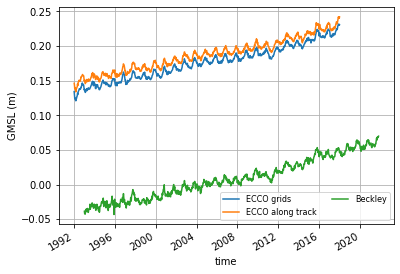

In [21]:
start_time = time.time()
ssh_weighted_mean.SSHA.plot(label='ECCO grids');
alongtrack_gmsl.plot(label='ECCO along track');
(gmsl_beckley.gmsl).plot(label='Beckley');
plt.grid()
plt.title('')
plt.ylabel('GMSL (m)')
plt.legend(ncol=2, loc='lower right',fontsize=8)
plt.savefig(fig_dir / 'GMSL_ecco_alongtrack_grids.png',dpi=200,transparent=False,facecolor='white')
print(time.time() - start_time)

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in arcsin
  return func(*(_execute_task(a, cache) for a in args))


250.5251805782318


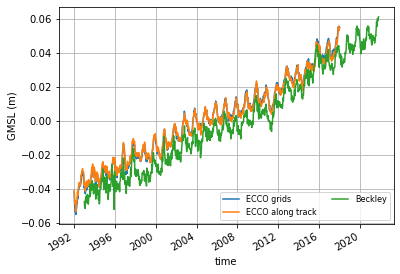

In [22]:
start_time = time.time()
(ssh_weighted_mean.SSHA-ssh_weighted_mean.SSHA.mean()).plot(label='ECCO grids');
(alongtrack_gmsl-alongtrack_gmsl.mean()).plot(label='ECCO along track');
# (gmsl_beckley.gmsl_nongia-gmsl_beckley.gmsl_nongia.mean()).plot(label='Beckley non GIA');
(gmsl_beckley.gmsl-gmsl_beckley.gmsl.mean()).plot(label='Beckley');
plt.grid()
plt.title('')
plt.ylabel('GMSL (m)')
plt.legend(ncol=2, loc='lower right',fontsize=8)
plt.savefig(fig_dir / 'GMSL_ecco_alongtrack_grids_beckley_refmean.png',dpi=200,transparent=False,facecolor='white')
print(time.time() - start_time)

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in arcsin
  return func(*(_execute_task(a, cache) for a in args))


252.61215353012085


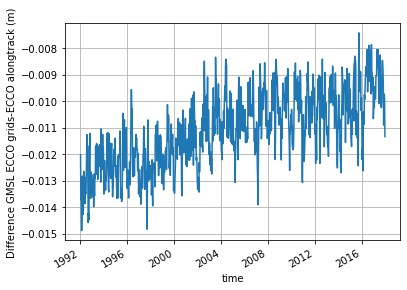

In [23]:
start_time = time.time()
(ssh_weighted_mean.SSHA.values-alongtrack_gmsl).plot();
plt.grid()
plt.title('')
plt.ylabel('Difference GMSL ECCO grids-ECCO alongtrack (m)')
plt.savefig(fig_dir / 'GMSL_diff_ecco_alongtrack_grids.png',dpi=200,transparent=False,facecolor='white')
print(time.time() - start_time)

# Compute GMSL from daily ECCO output

### Get data from the cloud

In [24]:
# ECCO_grid = xr.open_dataset(ECCO_grid_file)

In [3]:
%%capture
import requests

def store_aws_keys(endpoint: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):    
    with requests.get(endpoint, "w") as r:
        accessKeyId, secretAccessKey, sessionToken, expiration = list(r.json().values())

    creds ={}
    creds['AccessKeyId'] = accessKeyId
    creds['SecretAccessKey'] = secretAccessKey
    creds['SessionToken'] = sessionToken
    creds['expiration'] = expiration
    
    return creds

creds = store_aws_keys()
print(creds)

In [4]:
ShortName = "ECCO_L4_SSH_05DEG_DAILY_V4R4B"
# Ask PODAAC for the collection id
response = requests.get(
    url='https://cmr.earthdata.nasa.gov/search/collections.umm_json', 
    params={'provider': "POCLOUD",
            'ShortName': ShortName,
            'page_size': 1}
)
ummc = response.json()['items'][0]
ccid = ummc['meta']['concept-id']
print(f'collection id: {ccid}')

collection id: C2129181904-POCLOUD


In [5]:
s3 = s3fs.S3FileSystem(
    key=creds['AccessKeyId'],
    secret=creds['SecretAccessKey'],
    token=creds['SessionToken'],
    client_kwargs={'region_name':'us-west-2'},
)

In [6]:
# make a S3 'filesystem' object
fs = s3fs.S3FileSystem(anon=False,
                      key=creds['AccessKeyId'],
                      secret=creds['SecretAccessKey'],
                      token=creds['SessionToken'])

### Read data and compute GMSL

In [ ]:
ECCO_SSH_files = fs.glob(join("podaac-ops-cumulus-protected/", ShortName, '*.nc'))
#Load all of the files from AWS S3 using 'direct connection' and combine into a single xarray DataSet object
paths=[fs.open(f) for f in ECCO_SSH_files] 
ECCO_DS_daily = xr.open_mfdataset(
    paths=paths,
    combine='by_coords',
    # concat_dim='time',
    decode_cf=True,
    coords='minimal',
    chunks={'time': 1}  
)
ECCO_DS_daily.close()
ECCO_DS_daily
# weights = np.cos(np.deg2rad(ECCO_DS_daily.latitude))
# weights.name = "weights"
# ecco_weighted = ECCO_DS_daily.weighted(weights)
# ecco_weighted_mean = ecco_weighted.mean(("longitude", "latitude"))

#     #Extract the dynamic SSH field
#     ECCO_SSH = ECCO_DS_daily.SSH

#     ##Extract along-track SSH from ECCO mapped SSH
#     #Make the GridDefinition object for the mapping procedure (use pyresample)
#     ECCO_lons, ECCO_lats = np.meshgrid(ECCO_SSH.longitude, ECCO_SSH.latitude)
#     ECCO_grid_def = GridDefinition(lons=ECCO_lons, lats=ECCO_lats)